## The statistic analysis of the demographic data

1. Gender
2. Age
3. The difference of p-value before and after remove CR 

In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from data import Data

import warnings
warnings.filterwarnings('ignore')

# retina
%config InlineBackend.figure_format = 'retina'

In [2]:
def get_data(scale):
    '''
    Returns a dataframe with demographic information and the scale score
    '''
    demo = pd.read_csv('data/demographic.csv').query('age >= 13 and age <= 40 and gender in ("female", "male")')
    data = Data(scale)
    scale = data.df[['export_id', 'score', 'is_careless_response']]
    df = pd.merge(demo, scale, on='export_id')
    return df



In [3]:
def stat(df):
    result = {}

    male_scores = df.query('gender == "male"').score
    female_scores = df.query('gender == "female"').score

    print('gender')
    t_statistic, p_value = stats.ttest_ind(male_scores, female_scores)
    print(f"{round(t_statistic, 4)},{round(p_value, 4)}")
    print(f'male,{round(male_scores.mean(), 3)},{round(male_scores.std(), 3)}')
    print(f'female,{round(female_scores.mean(), 3)},{round(female_scores.std(), 3)}')

    result['gender'] = {}
    result['gender']['t'] = t_statistic
    result['gender']['p'] = p_value

    # 将年龄分为几个段，例如: <18, 18-30, 31-40, 41-50, >50
    bins = [0, 18, 21, 24, 30]
    labels = ['<18', '18-21', '21-24', '24-30']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

    print('age')
    # 进行方差分析
    age_groups = [df['score'][df['age_group'] == label] for label in labels]
    f_value, p_value = stats.f_oneway(*age_groups)
    print(f"{round(f_value, 4)},{round(p_value, 4)}")
    for label in labels:
        print(f"{label},{round(df['score'][df['age_group'] == label].mean(),3)},{round(df['score'][df['age_group'] == label].std(),3)}")    

    result['age'] = {}
    result['age']['f'] = f_value
    result['age']['p'] = p_value
    
    return result



In [4]:
data = get_data('isi')
result = stat(data.query('is_careless_response == False'))

gender
2.6464,0.0081
male,3.031,3.675
female,2.895,3.323
age
4.2884,0.0049
<18,3.309,3.883
18-21,2.919,3.353
21-24,3.008,3.553
24-30,2.701,3.447


In [5]:
result_gender = pd.DataFrame(columns=['scale', 'cr', 't', 'p'])
result_age = pd.DataFrame(columns=['scale', 'cr', 'f', 'p'])


def generate_results(scale = 'phq9'):

    gender = []
    age = []
    data = get_data(scale)
    result = stat(data)
    gender.append({
        'scale': scale,
        'cr': 'before',
        't': result['gender']['t'],
        'p': result['gender']['p'],
    })
    age.append({
        'scale': scale,
        'cr': 'before',
        'f': result['age']['f'],
        'p': result['age']['p'],
    })

    result = stat(data.query('is_careless_response == False'))
    gender.append({
        'scale': scale,
        'cr': 'after',
        't': result['gender']['t'],
        'p': result['gender']['p'],
    })
    age.append({
        'scale': scale,
        'cr': 'after',
        'f': result['age']['f'],
        'p': result['age']['p'],
    })

    return gender, age

gender_result = []
age_result = []

for scale in ['phq9', 'gad7', 'isi', 'pss']:
    gender, age = generate_results(scale)
    gender_result += gender
    age_result += age



gender
-4.5845,0.0
male,3.118,3.856
female,3.345,3.609
age
11.8337,0.0
<18,4.205,4.465
18-21,3.327,3.619
21-24,3.232,3.775
24-30,2.905,3.791
gender
-3.8211,0.0001
male,3.288,3.832
female,3.488,3.615
age
11.57,0.0
<18,4.299,4.446
18-21,3.501,3.614
21-24,3.362,3.768
24-30,3.057,3.766
gender
-5.9759,0.0
male,1.763,2.972
female,1.996,2.878
age
7.8033,0.0
<18,2.76,3.823
18-21,1.862,2.801
21-24,1.961,2.995
24-30,1.917,3.105
gender
-2.4477,0.0144
male,2.103,3.093
female,2.214,2.934
age
5.9161,0.0005
<18,2.952,3.594
18-21,2.122,2.87
21-24,2.237,3.088
24-30,2.171,3.151
gender
0.0189,0.9849
male,2.777,3.642
female,2.776,3.311
age
6.7523,0.0002
<18,3.33,3.831
18-21,2.767,3.336
21-24,2.835,3.553
24-30,2.502,3.435
gender
2.6464,0.0081
male,3.031,3.675
female,2.895,3.323
age
4.2884,0.0049
<18,3.309,3.883
18-21,2.919,3.353
21-24,3.008,3.553
24-30,2.701,3.447
gender
4.2811,0.0
male,20.29,8.348
female,19.813,8.3
age
5.5899,0.0008
<18,21.225,8.448
18-21,19.803,8.168
21-24,20.184,8.432
24-30,20.164,8.688

In [6]:
gender_result_df = pd.DataFrame(gender_result)
age_result_df = pd.DataFrame(age_result)
gender_result_df.to_csv('gender_p_change.csv', index=False)
age_result_df.to_csv('age_p_change.csv', index=False)

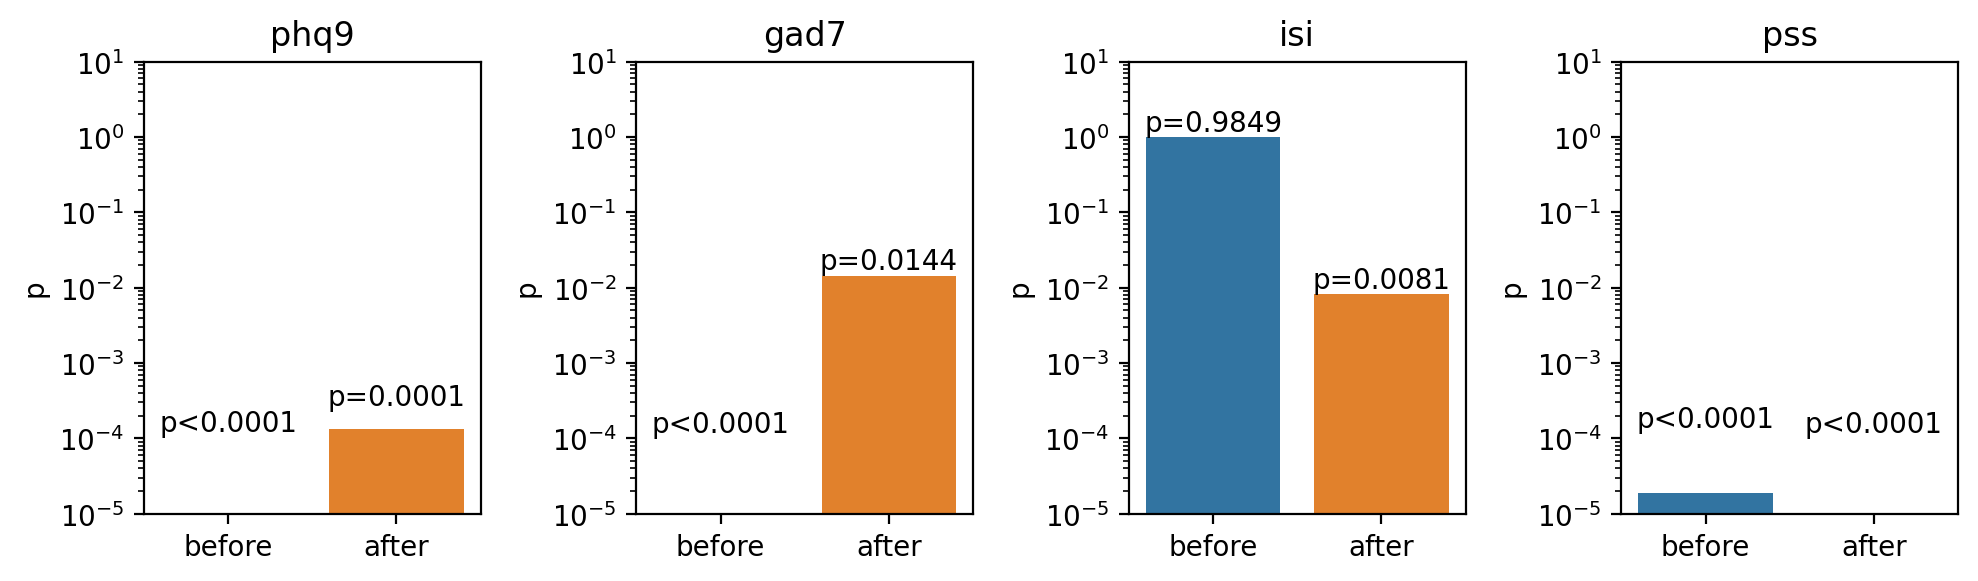

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax_dic = {}
ax_dic['phq9'] = ax[0]
ax_dic['gad7'] = ax[1]
ax_dic['isi'] = ax[2]
ax_dic['pss'] = ax[3]

for name, df_grp in gender_result_df.groupby('scale'):
    sns.barplot(data=df_grp, x='cr', y='p', ax=ax_dic[name])
    for p, bar in zip(df_grp['p'], ax_dic[name].patches):
        if p < 0.0001:
            text = 'p<0.0001'
        else:
            text = f'p={round(p, 4)}'
        ax_dic[name].text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.0001, text, ha='center', va='bottom')
    ax_dic[name].set_title(name)
    ax_dic[name].set_xlabel('')
    ax_dic[name].set_yscale('log')
    ax_dic[name].set_ylim(10e-6, 10)
    


plt.tight_layout()

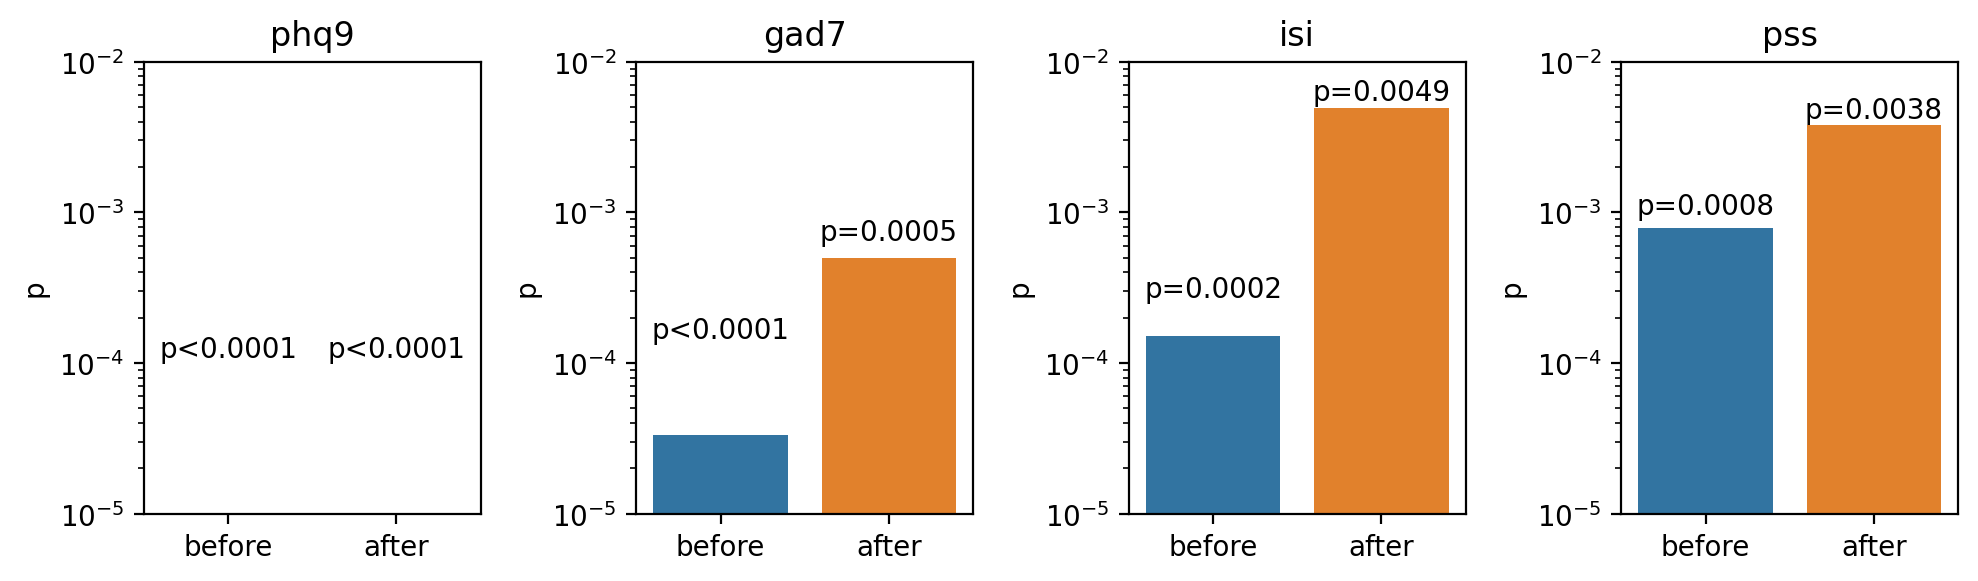

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax_dic = {}
ax_dic['phq9'] = ax[0]
ax_dic['gad7'] = ax[1]
ax_dic['isi'] = ax[2]
ax_dic['pss'] = ax[3]


for name, df_grp in age_result_df.groupby('scale'):
    sns.barplot(data=df_grp, x='cr', y='p', ax=ax_dic[name])
    ax_dic[name].set_title(name)
    ax_dic[name].set_xlabel('')
    ax_dic[name].set_yscale('log')
    ax_dic[name].set_ylim(10e-6, 10e-3)
    for p, bar in zip(df_grp['p'], ax_dic[name].patches):
        if p < 0.0001:
            text = 'p<0.0001'
        else:
            text = f'p={round(p, 4)}'
        ax_dic[name].text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.0001, text, ha='center', va='bottom')


plt.tight_layout()